In [59]:
import aux_tools
import os
%matplotlib inline

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(os.getcwd(), fig_id + "." + fig_extension)
    print(f"Saving figure {fig_id} to {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [62]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

In [63]:
# Pipeline

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #('imputer', Imputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('selector', aux_tools.DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    #('robust_scaler', RobustScaler()),
])

sliding_window_pipeline = Pipeline([
    ('selector', aux_tools.DataFrameSelector('relative_day_position')),
    ('revel', aux_tools.DataFrameRevel()),
    ('cat_encoder', aux_tools.CategoricalEncoder(encoding="onehot-dense")),
])


In [65]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("sliding_window_pipeline", sliding_window_pipeline),
])

In [66]:
from sklearn.utils import shuffle

df = shuffle(df)

fulldata = full_pipeline.fit_transform(df)
cat_encoder = aux_tools.CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [12]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

nn_class = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(15,), random_state=42)


scores = cross_val_score(nn_class,
                         fulldata,
                         fulldata_labels_ordinal.ravel()
                         #scoring='accuracy'
                        )

print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.0023)


Automatically created module for IPython interactive environment
Normalized confusion matrix
[[1.00e+00 0.00e+00 2.24e-04 1.12e-04 0.00e+00 1.12e-04]
 [2.35e-04 9.95e-01 3.88e-03 0.00e+00 0.00e+00 4.71e-04]
 [5.27e-04 8.70e-03 9.81e-01 2.37e-03 2.90e-03 4.22e-03]
 [0.00e+00 1.29e-04 9.06e-04 9.85e-01 1.33e-02 2.59e-04]
 [0.00e+00 4.72e-04 7.86e-04 1.78e-02 9.81e-01 1.57e-04]
 [0.00e+00 6.70e-04 3.68e-03 1.34e-03 3.01e-03 9.91e-01]]
Saving figure conf_mat to /home/luminoso/thesis/gjc-ml-2018abr_final/conf_mat.pdf
Normalized confusion matrix
[[0.   0.   0.5  0.25 0.   0.25]
 [0.05 0.   0.85 0.   0.   0.1 ]
 [0.03 0.46 0.   0.13 0.15 0.23]
 [0.   0.01 0.06 0.   0.91 0.02]
 [0.   0.02 0.04 0.93 0.   0.01]
 [0.   0.08 0.42 0.15 0.35 0.  ]]
Saving figure conf_mat_errors to /home/luminoso/thesis/gjc-ml-2018abr_final/conf_mat_errors.pdf


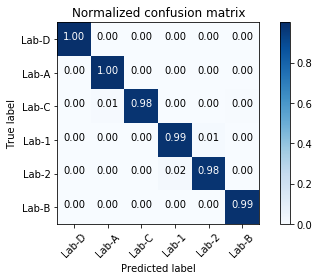

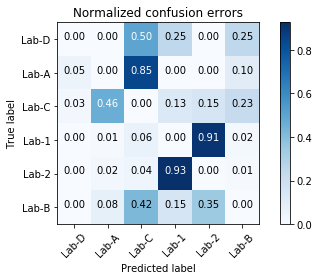

In [18]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

X = fulldata
y = fulldata_labels_ordinal.ravel()

class_names = [aux_tools.labnames[x] for x in list(cat_encoder.categories_[0])]


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(15,), random_state=42)

classifier.fit(X, y)

y_pred = cross_val_predict(classifier, X, y, cv=3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

save_fig('conf_mat')


plt.figure()

row_sums = cnf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = cnf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion errors')

save_fig('conf_mat_errors')

plt.show()

In [19]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(fulldata)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Saving figure pca_variance_095 to /home/luminoso/thesis/gjc-ml-2018abr_final/pca_variance_095.pdf


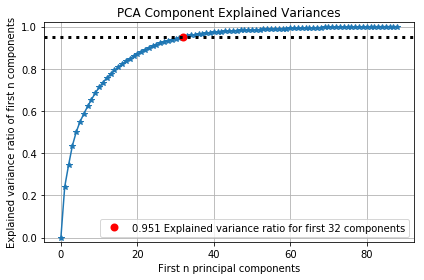

In [20]:
import scikitplot as skplt

skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.95)
save_fig('pca_variance_095')
plt.show()


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    #('reduce_dim', PCA()),
    #('reduce_dim', None,),
    ('classify', None)
])

param_grid= [
    {
        #'reduce_dim': [PCA()],
        #'reduce_dim__n_components': [2, 3, 5, 7, 37, 41, 43, 47, 53, 59, 73, 79, 83,],
        #'reduce_dim__n_components': [73, 83,],
        'classify': [MLPClassifier(random_state=42)],
        'classify__solver': ['lbfgs','adam'],
        'classify__alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
    },
]

param_grid = [
      {'solver': ['lbfgs','adam'],'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]}
   ]

nn_clas = MLPClassifier(random_state=42)

grid_search_nn = GridSearchCV(nn_clas, param_grid, cv=5,
                           #scoring='neg_mean_squared_error',
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=6,
                           verbose=True)
grid_search_nn.fit(fulldata,
                    fulldata_labels_ordinal.ravel())



Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed: 26.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid=[{'solver': ['lbfgs', 'adam'], 'alpha': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [43]:
cvres = grid_search_nn.cv_results_
cvres.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [48]:
for mean_score, std, params in zip(cvres['mean_test_score'], cvres['std_test_score'], cvres["params"]):
    print(f"{mean_score} +- {std*2} : {params}")


0.9933672803238021 +- 0.0014641120751548364 : {'alpha': 0.1, 'solver': 'lbfgs'}
0.9893197545371458 +- 0.0028663533567020475 : {'alpha': 0.1, 'solver': 'adam'}
0.9922444183313749 +- 0.0021182893468259857 : {'alpha': 0.01, 'solver': 'lbfgs'}
0.9928450189319754 +- 0.0016305971969819012 : {'alpha': 0.01, 'solver': 'adam'}
0.9928711320015667 +- 0.002220455387392296 : {'alpha': 0.001, 'solver': 'lbfgs'}
0.9930278104191148 +- 0.0025474034944246494 : {'alpha': 0.001, 'solver': 'adam'}
0.9926100013056535 +- 0.002041017881174121 : {'alpha': 0.0001, 'solver': 'lbfgs'}
0.9930016973495235 +- 0.0025526208445196003 : {'alpha': 0.0001, 'solver': 'adam'}
0.9928189058623841 +- 0.002437925090905639 : {'alpha': 1e-05, 'solver': 'lbfgs'}
0.9928450189319754 +- 0.002414172889767855 : {'alpha': 1e-05, 'solver': 'adam'}
0.9931061496278888 +- 0.0017504564188470986 : {'alpha': 1e-06, 'solver': 'lbfgs'}
0.9930016973495235 +- 0.0024596930014398038 : {'alpha': 1e-06, 'solver': 'adam'}
0.9929233581407494 +- 0.002149

In [52]:
np.std(cvres['mean_test_score']*100) * 2

0.1901517620189271

In [ ]:
# confusion matrix

Automatically created module for IPython interactive environment
Normalized confusion matrix
[[1.00e+00 0.00e+00 2.24e-04 0.00e+00 2.24e-04 0.00e+00]
 [0.00e+00 9.94e-01 4.00e-03 8.23e-04 0.00e+00 8.23e-04]
 [1.58e-03 1.56e-02 9.68e-01 7.91e-03 4.22e-03 2.64e-03]
 [0.00e+00 0.00e+00 0.00e+00 9.58e-01 4.15e-02 1.29e-04]
 [1.57e-04 0.00e+00 1.57e-04 5.08e-02 9.49e-01 0.00e+00]
 [6.70e-04 2.01e-03 2.34e-03 1.00e-03 1.00e-03 9.93e-01]]
Saving figure conf_mat_NN to /home/luminoso/thesis/gjc-ml-2018abr_final/conf_mat_NN.pdf
Normalized confusion matrix
[[0.   0.   0.5  0.   0.5  0.  ]
 [0.   0.   0.71 0.15 0.   0.15]
 [0.05 0.49 0.   0.25 0.13 0.08]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.99 0.   0.  ]
 [0.1  0.29 0.33 0.14 0.14 0.  ]]
Saving figure conf_mat_errors_NN to /home/luminoso/thesis/gjc-ml-2018abr_final/conf_mat_errors_NN.pdf


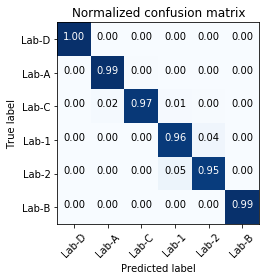

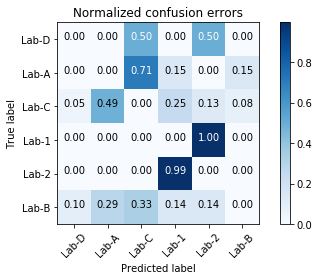

In [57]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, colorbar=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

X = fulldata
y = fulldata_labels_ordinal.ravel()


class_names = [aux_tools.labnames[x] for x in list(cat_encoder.categories_[0])]


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.LinearSVC(loss='hinge',max_iter=5000, C=1)
classifier.fit(X, y)

y_pred = cross_val_predict(classifier, X, y, cv=3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix', colorbar=False)

save_fig('conf_mat_NN')


plt.figure()

row_sums = cnf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = cnf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion errors')

save_fig('conf_mat_errors_NN')

plt.show()

In [ ]:
# remove everything except the worse case

In [76]:
df_worsecase = df[df.entity != 'np_x58pc.raw']
df_worsecase = df_worsecase[df_worsecase.entity != 'np_tohiba.raw']
df_worsecase = df_worsecase[df_worsecase.entity != 'np_freebsd.raw'] 
df_worsecase = df_worsecase[df_worsecase.entity != 'np_nuc.raw'] 

In [90]:
fulldata_worsecase = full_pipeline.fit_transform(df_worsecase)
cat_encoder = aux_tools.CategoricalEncoder(encoding="ordinal")
fulldata_labels = df_worsecase['entity'].values.reshape(-1, 1)
fulldata_worsecase_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [100]:
df_bestcase = df[df.entity != 'np_x58pc.raw']
df_bestcase = df_bestcase[df_bestcase.entity != 'np_windows10x86.raw']
#df_bestcase = df_bestcase[df_bestcase.entity != 'np_tohiba.raw']
df_bestcase = df_bestcase[df_bestcase.entity != 'np_freebsd.raw'] 
df_bestcase = df_bestcase[df_bestcase.entity != 'np_nuc.raw'] 

In [101]:
fulldata_bestcase = full_pipeline.fit_transform(df_bestcase)
cat_encoder = aux_tools.CategoricalEncoder(encoding="ordinal")
fulldata_labels = df_bestcase['entity'].values.reshape(-1, 1)
fulldata_bestcase_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [102]:
[aux_tools.labnames[x] for x in list(cat_encoder.categories_[0])]

['Lab-C', 'Lab-1']

Automatically created module for IPython interactive environment
Saving figure nn_alphas to /home/luminoso/thesis/gjc-ml-2018abr_final/nn_alphas.pdf


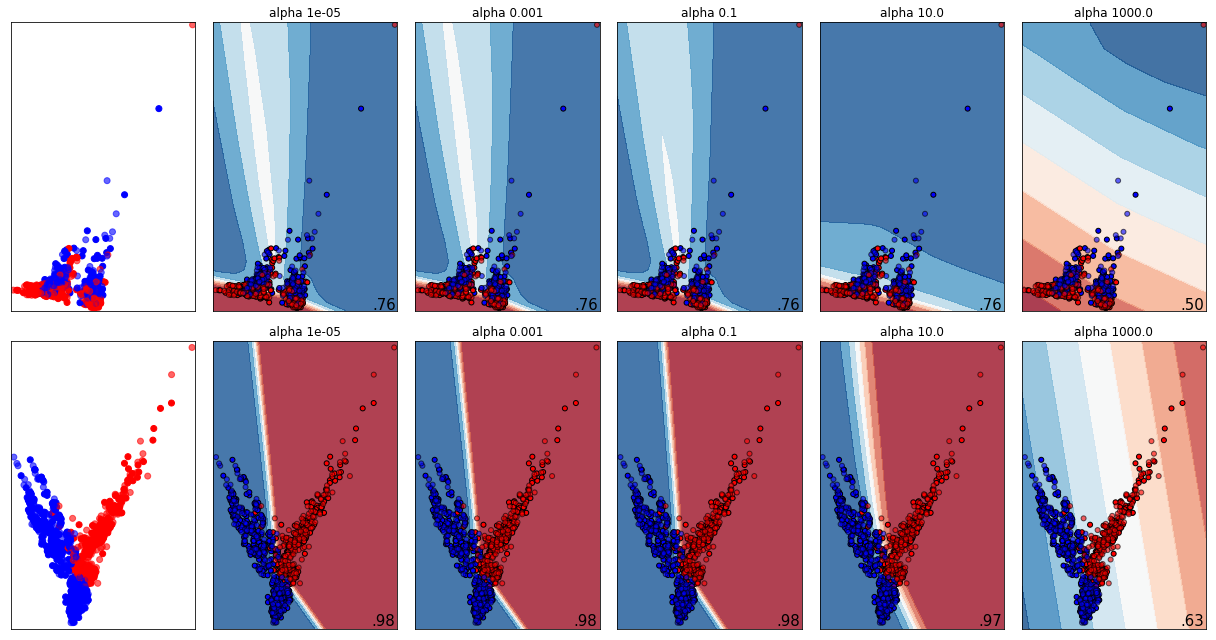

In [129]:
print(__doc__)


# Author: Issam H. Laradji
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier

h = .02  # step size in the mesh

alphas = np.logspace(-5, 3, 5)
#alphas = 10.0 ** -np.arange(1, 7)
names = []
for i in alphas:
    names.append('alpha ' + str(i))

classifiers = []
for i in alphas:
    classifiers.append(MLPClassifier(alpha=i,
                                     random_state=42,
                                     max_iter=600))

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

SIZE = 1000

datasets = [(fulldata_worsecase[:SIZE], fulldata_worsecase_labels_ordinal.ravel()[:SIZE]),
            (fulldata_bestcase[:SIZE],  fulldata_bestcase_labels_ordinal.ravel()[:SIZE])]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for X, y in datasets:
    # preprocess dataset, split into training and test part
    pca = PCA(n_components=2)
    pca.fit(X)
    
    X = pca.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='black', s=25)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6, edgecolors='black', s=25)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
save_fig('nn_alphas')
plt.show()